# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 데이터베이스 튜토리얼

In [1]:
!pip install -q chromadb transformers

## Dataset

식품의약품안전처_인공지능 개발을 위한 알약 이미지 데이터

https://www.data.go.kr/data/15112582/fileData.do

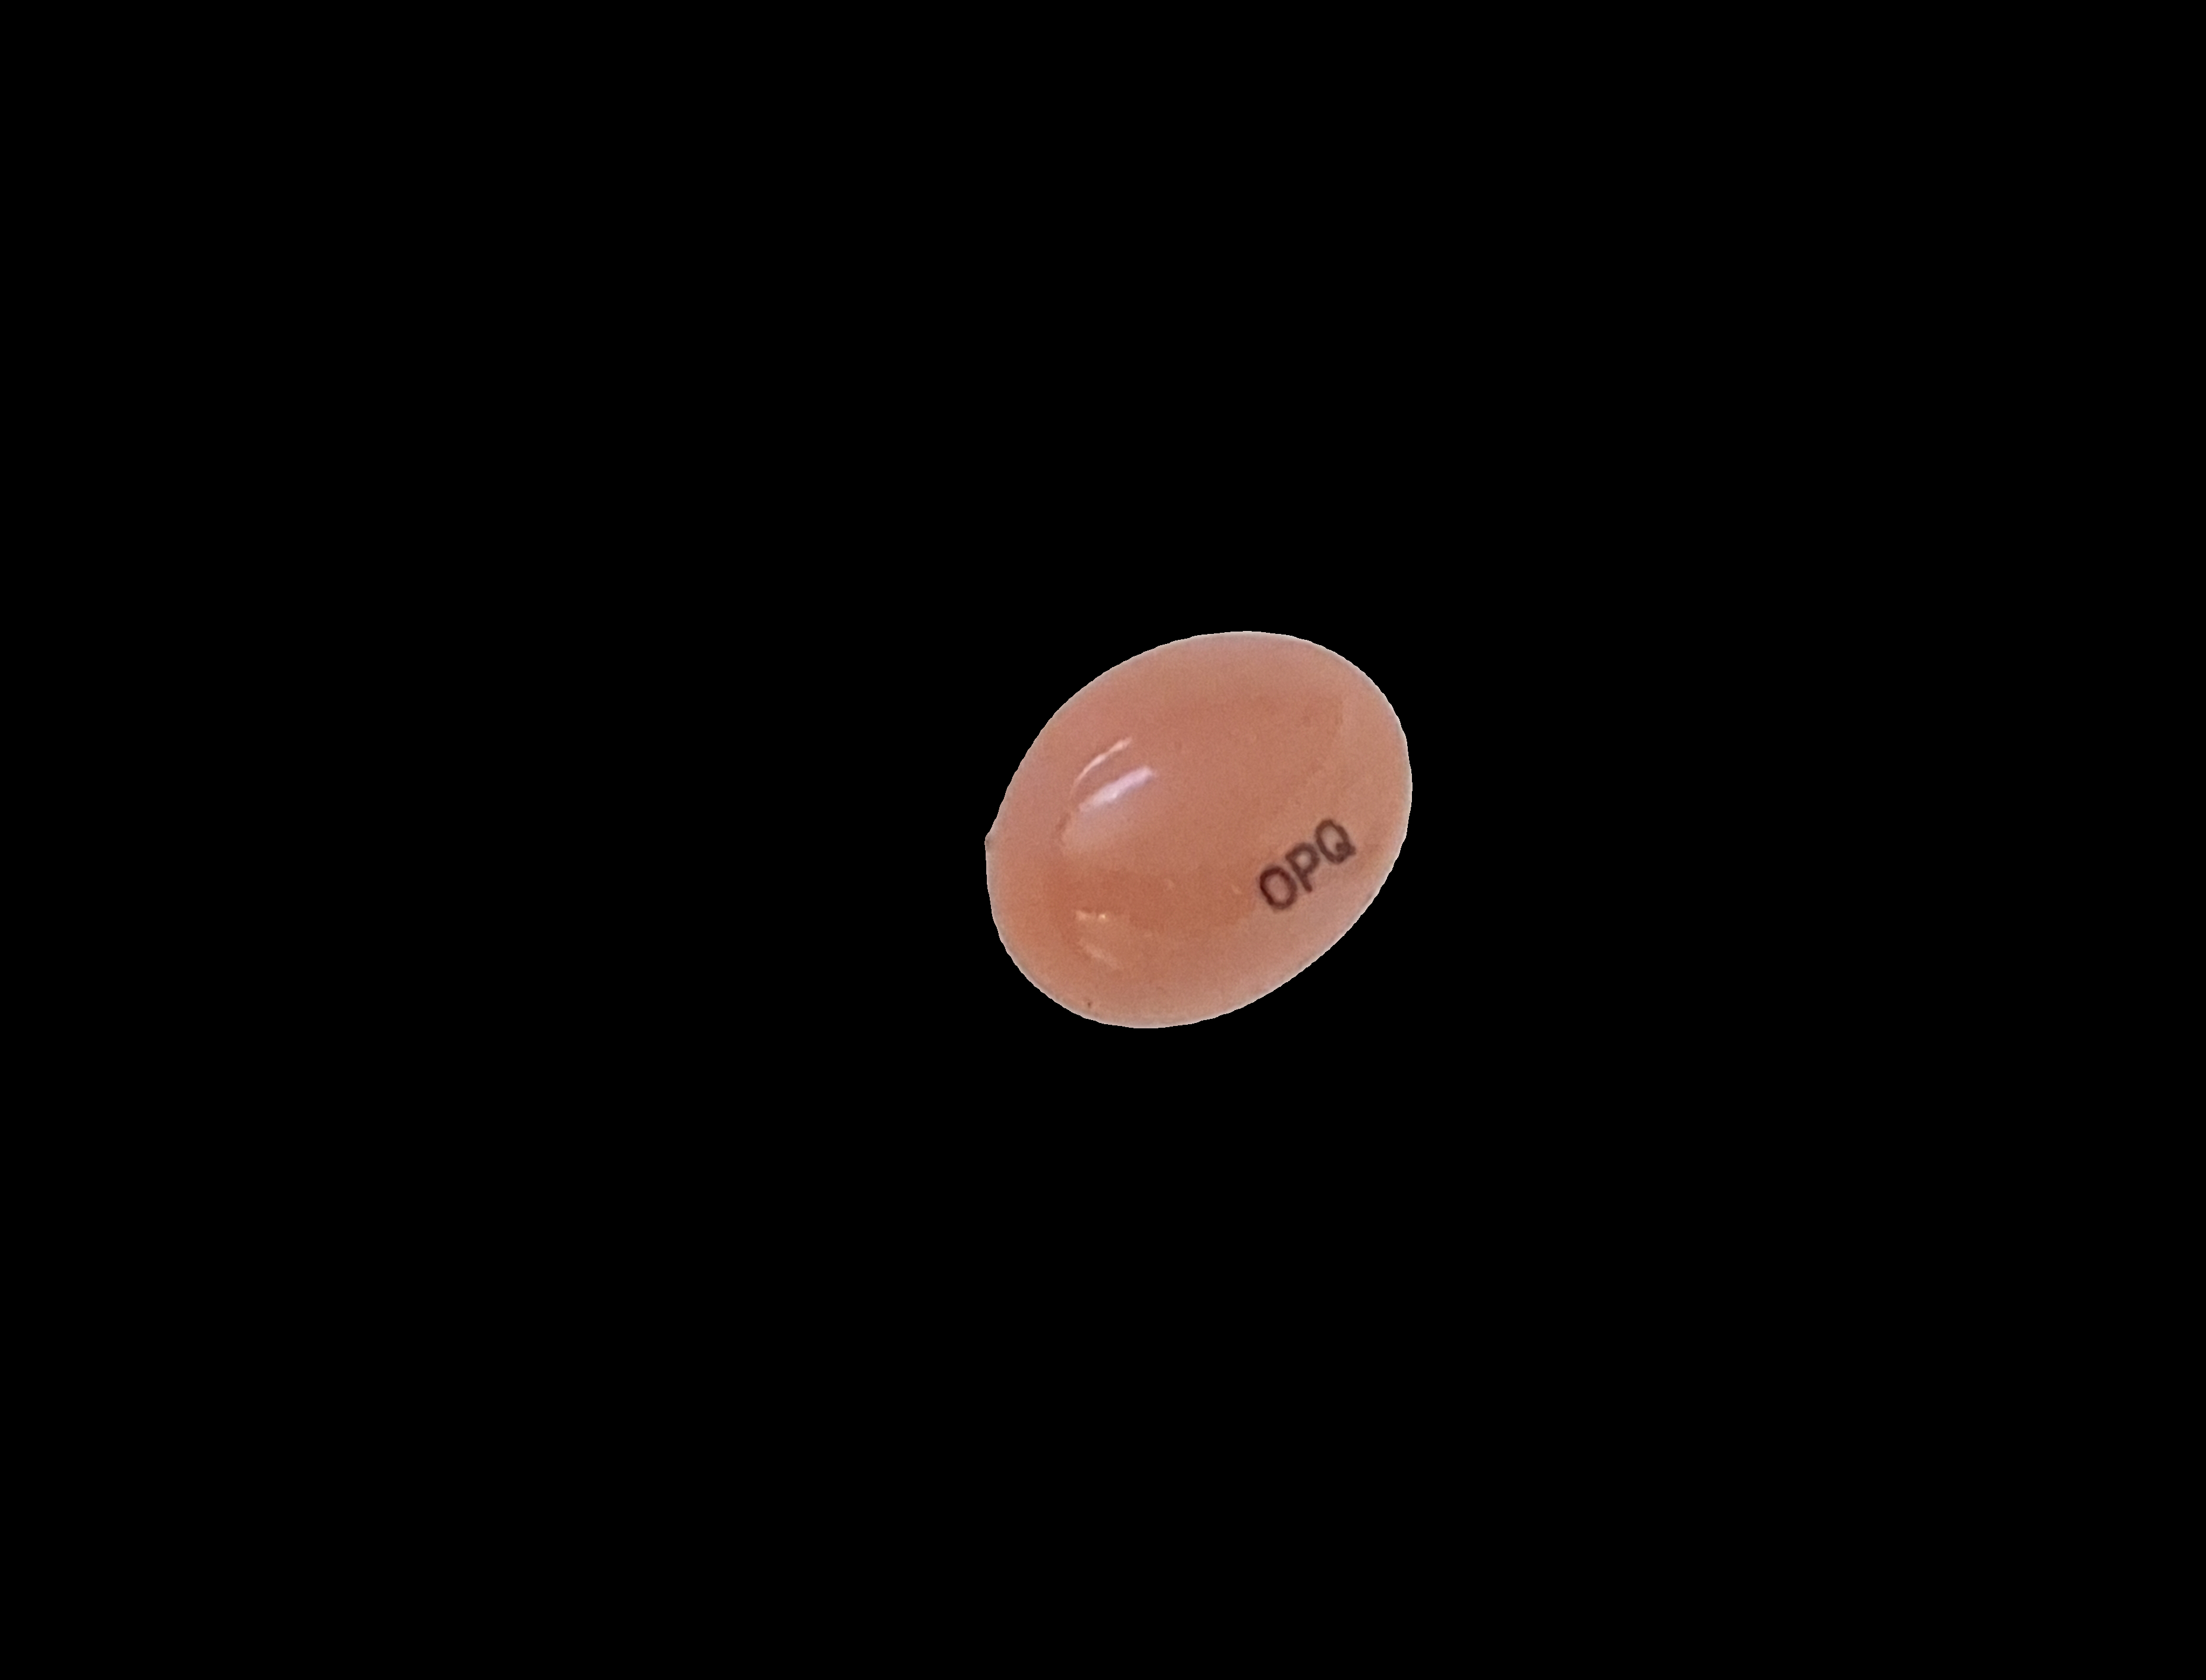

In [2]:
from PIL import Image

img = Image.open("data/29002/IMG_20201202_163857.png").convert("RGB")

img

## Image Vectorizer 모델 로드

In [3]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16')

print("Models loaded!")

/opt/miniconda3/envs/mlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/mlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/miniconda3/envs/mlp/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You 

Models loaded!


## Embedding

In [4]:
img_tensor = feature_extractor(images=[img], return_tensors="pt")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding

array([-0.66727144,  0.5812908 , -0.9910268 ,  0.7473024 ,  0.11718994,
        0.9832842 ,  0.721835  , -0.99401385,  0.20385766, -0.5002286 ,
        0.95340985,  0.5702039 ,  0.9161946 ,  0.82754517,  0.99633294,
       -0.9968719 ,  0.9598983 ,  0.9944389 , -0.57038367, -0.09952305,
       -0.99101454, -0.98428196,  0.9787921 ,  0.6026652 ,  0.9928727 ,
        0.6585371 ,  0.7814652 ,  0.33331877, -0.9376524 , -0.7159169 ,
       -0.8409282 , -0.99996984, -0.9994537 ,  0.03705354,  0.24198262,
       -0.889824  ,  0.9909165 , -0.40799552, -0.5248876 , -0.96397364,
       -0.79666   , -0.9972967 , -0.80197185, -0.5060988 ,  0.7404161 ,
        0.01248068,  0.9877027 , -0.10045713,  0.98143506,  0.86304486,
        0.74528676,  0.63675165,  0.34829625,  0.98783773, -0.77660686,
       -0.98682547, -0.9412647 ,  0.99814993,  0.9343781 , -0.9993135 ,
       -0.59435266,  0.25441003, -0.833948  ,  0.9499373 , -0.676001  ,
       -0.99907935, -0.99974465, -0.9780192 , -0.7205016 , -0.78

## Chroma DB

In [6]:
import chromadb

client = chromadb.PersistentClient(path="chroma_db_medicine")

collection = client.get_or_create_collection("medicine")

In [7]:
from glob import glob

img_list = sorted(glob("data/*/*.png"))

len(img_list)

920

In [8]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path).convert("RGB")
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=[img], return_tensors="pt")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()
    embedding_to_list = embedding.tolist()

    embeddings.append(embedding_to_list)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 920/920 [02:22<00:00,  6.46it/s]

Done!


In [9]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

print("✅ Database automatically saved with PersistentClient!")

✅ Database automatically saved with PersistentClient!


In [10]:
import requests
import matplotlib.pyplot as plt


def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
    test_embedding_list = test_embedding.tolist()

    query_result = collection.query(
        query_embeddings=[test_embedding_list],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

{'ids': [['306', '312', '302']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'name': '40767', 'uri': 'data/40767/IMG_20201125_132817.png'},
   {'name': '40767', 'uri': 'data/40767/IMG_20201125_132825.png'},
   {'uri': 'data/40767/IMG_20201125_132812.png', 'name': '40767'}]],
 'distances': [[288.8897705078125, 291.68414306640625, 292.15765380859375]]}

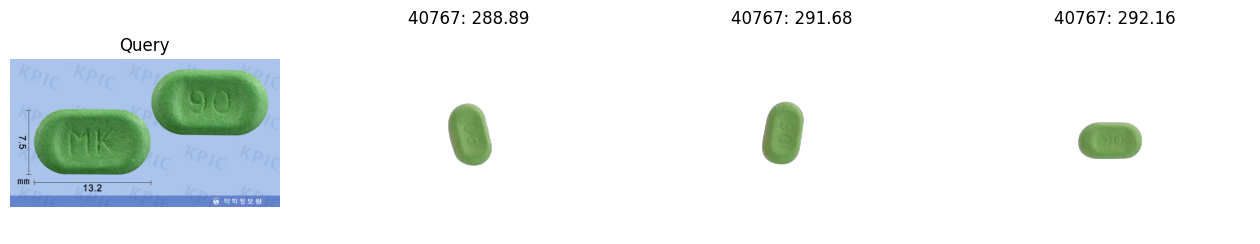

In [11]:
query("https://www.pharm.or.kr/images/sb_photo/big3/201901250011601.jpg")